In [1]:
import pandas as pd 
from datetime import datetime
import Accuracy_calculate as accuracy_calc
from dateutil.relativedelta import relativedelta
import query_traffic_elastic as elastic_trafic
import model_cuantiles as mod_cuant
import matplotlib.pyplot as plt
from datetime import date
import statsmodels.formula.api as smf
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from datetime import timedelta, date
from pylab import rcParams
import math


C:\Users\Alejandro\anaconda3\lib\site-packages\elasticsearch\connection\http_urllib3.py:189: UserWarning: Connecting to https://traful-apielastic.wh.telefonica:443 using SSL with verify_certs=False is insecure.
  % self.host
C:\Users\Alejandro\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'traful-apielastic.wh.telefonica'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Connected {'name': 'elasticsearch-master-2', 'cluster_name': 'elasticsearch', 'cluster_uuid': 'umvfPipzQXKC3Egj5WHbyA', 'version': {'number': '7.3.0', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'de777fa', 'build_date': '2019-07-24T18:30:11.767338Z', 'build_snapshot': False, 'lucene_version': '8.1.0', 'minimum_wire_compatibility_version': '6.8.0', 'minimum_index_compatibility_version': '6.0.0-beta1'}, 'tagline': 'You Know, for Search'}


In [2]:
def pipe_model_forecast(df_train,bw,key):
        #Obtener el sesgo de los datos de entrenamiento 
        sesgo=mod_cuant.quartileSkewness ( serie=df_train)
        sesgo_median=sesgo.dropna().median()
        umbral_list = [sesgo_median for i in range(sesgo.index.shape[0])]
        plt.figure(figsize=(15, 5))
        plt.plot( sesgo.index, sesgo.values, markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2,label='sesgo')
        plt.plot( sesgo.index, umbral_list, markerfacecolor='blue', markersize=12, color='red', linewidth=2,label='median_sesgo')
        
        #Call to the model to return the predictiond and the timestamp asociate to model overcomes banwith 
        fechaSupera, predicciones = mod_cuant.regresionesPercetiles(df_train,[0.95,0.9,0.75,0.5,0.25],2,14,.8)
        #Interpolate quantil 75
        predicciones["interpolate_75"] = predicciones[['0.5','0.25']].apply(lambda row: (2*row['0.5']-(row['0.25']*(sesgo_median+1)))/(1-sesgo_median), axis=1)
        
        predicciones["iqr"]=predicciones[['interpolate_75','0.25']].apply(lambda row: (row['interpolate_75']-(row['0.25'])), axis=1)
        #predicciones["uper_bound"]=predicciones[['0.75','iqr']].loc[fechas.tail(1).index[0]:].apply(lambda row: (row['0.75']+(1.5*row['iqr'])), axis=1)
        predicciones["inter_uper_bound"]=predicciones[['interpolate_75','iqr']].apply(lambda row: (row['interpolate_75']+(1.5*row['iqr'])), axis=1)
        predicciones["inter_lower_bound"]=predicciones[['0.25','iqr']].apply(lambda row: (row['0.25']-(1.5*row['iqr'])), axis=1)
        predicciones["dif_btw_bw"]=predicciones[["inter_uper_bound"]].apply(lambda row: (int(bw)-(row['inter_uper_bound'])), axis=1)
        plt.figure(figsize=(15, 5))
        plt.plot( df_train.index, df_train.values, 'o', alpha=.1, zorder=0,label='Data')
        plt.plot( predicciones.index[0:-1], predicciones["0.75"][0:-1].values, markerfacecolor='blue', markersize=12, color='gold', linewidth=2,label='percetin 0.75')
        plt.plot( predicciones.index[0:-1], predicciones["interpolate_75"][0:-1].values, markerfacecolor='blue', markersize=12, color='red', linewidth=2,label='interpolate_75')
        plt.plot( predicciones.index[0:-1], predicciones["inter_uper_bound"][0:-1].values, markerfacecolor='blue', markersize=12, color='green', linewidth=2,label='inter_upper_bound')
        plt.plot( predicciones.index[0:-1], predicciones["inter_lower_bound"][0:-1].values, markerfacecolor='blue', markersize=12, color='green', linewidth=2,label='inter_lower_bound')
        plt.plot( predicciones.index[0:-1], predicciones["0.95"][0:-1].values, markerfacecolor='blue', markersize=12, color='red', linewidth=2,label='0.95')
        plt.plot( predicciones.index[0:-1], predicciones["0.5"][0:-1].values, markerfacecolor='blue', markersize=12, color='brown', linewidth=2,label='median')
        plt.plot( predicciones.index[0:-1], predicciones["0.25"][0:-1].values, markerfacecolor='blue', markersize=12, color='brown', linewidth=2,label='0.25')
        plt.plot( predicciones.index[0:-1], [int(bw) for i in range(predicciones.index[0:-1].shape[0])], markerfacecolor='blue', markersize=12, color='purple', linewidth=2,label='BW')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


In [3]:
        
def pytime_elasticTime(time):
    now = str(time).replace(" ","T")+"Z"
    return now
#A partir de los meses introducidos te devuelve la fecha de hoy y la fecha de los meses trascurrido
def timestamp_elasticsearch_now_n_now(meses):
    now=datetime.now()
    befor_now=now-relativedelta(months=meses)
    return pytime_elasticTime(now),pytime_elasticTime(befor_now)

def timestamp_elasticsearch_timestap_n_month(timestamp,meses):
    now=date.fromisoformat(timestamp)
    befor_now=now-relativedelta(months=meses)
    return pytime_elasticTime(now),pytime_elasticTime(befor_now)


In [44]:

#calculamos la fecha de hoy y la fecha para los meses anteriores añadida now=now,befor_now=now-meses
#elk_timestamp=timestamp_elasticsearch_now_n_now(2)
elk_timestamp=timestamp_elasticsearch_timestap_n_month("2020-04-01",4)
#Query to elasticsearch to from the dataset
#request trafic for sabm
#reque_trafic=elastic_trafic.request_trafic_data(elk_timestamp[1].replace("Z", ""),elk_timestamp[0].replace("Z", ""),"sabm-col-baq-mw-m-386781_GigabitEthernet0/0.1100")
reque_trafic=elastic_trafic.request_trafic_data(elk_timestamp[1].replace("Z", ""),elk_timestamp[0].replace("Z", ""),"cmex-mex-occrtriw01_GigabitEthernet0/0/0")
#reque_trafic=elastic_trafic.request_trafic_data(elk_timestamp[1].replace("Z", ""),elk_timestamp[0].replace("Z", ""),"bbva-ven-ccs-mp-m-035864_GigabitEthernet0/1")
#reque_trafic=elastic_trafic.request_trafic_data(elk_timestamp[1].replace("Z", ""),elk_timestamp[0].replace("Z", ""),"bbva-col-bog-mw-2-1004210_TenGigabitEthernet0/1/0.112")
#reque_trafic=elastic_trafic.request_trafic_data(elk_timestamp[1].replace("Z", ""),elk_timestamp[0].replace("Z", ""),'bbva-col-bog-mw-2-1004210_TenGigabitEthernet0/1/0.101')

#dataset trafic 
df_traffic=elastic_trafic.trafic_request_to_df(reque_trafic)
#Clean dataset to 
df_traffic.set_index(pd.DatetimeIndex(df_traffic['data_time']),inplace=True)
df_train=df_traffic[["Inbps","Outbps"]].astype("int64")


C:\Users\Alejandro\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'traful-apielastic.wh.telefonica'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
C:\Users\Alejandro\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'traful-apielastic.wh.telefonica'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
C:\Users\Alejandro\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'traful-apielastic.wh.telefonica'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnin

C:\Users\Alejandro\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'traful-apielastic.wh.telefonica'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
C:\Users\Alejandro\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'traful-apielastic.wh.telefonica'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
C:\Users\Alejandro\anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'traful-apielastic.wh.telefonica'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnin

In [6]:
def quantile_df(df,quantile,key):
    return df.resample('1h').apply(lambda x: x.quantile(quantile))
#Sesgo de los cuantiles 
def quartileSkewness (serie,key,UB=0.75,M=0.5,LB=0.25):
    ub=quantile_df(serie,UB,key).dropna()
    m=quantile_df(serie,M,key).dropna()
    lb=quantile_df(serie,LB,key).dropna()
    C = (ub+lb-2*m)/(ub-lb)
    #C = (lb-(ub-lb))/(14*0.8)
    #C = np.median(C)
    return C.dropna()


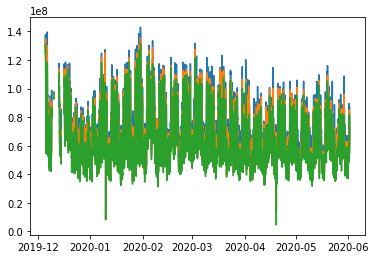

In [7]:


plt.plot(df_train[["Inbps"]].resample('1h').apply(lambda x: x.quantile(0.75)))
plt.plot(df_train[["Inbps"]].resample('1h').apply(lambda x: x.quantile(0.5)))
plt.plot(df_train[["Inbps"]].resample('1h').apply(lambda x: x.quantile(0.25)))

C:\Users\Alejandro\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\Alejandro\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\Alejandro\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\Alejandro\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\Alejandro\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached."

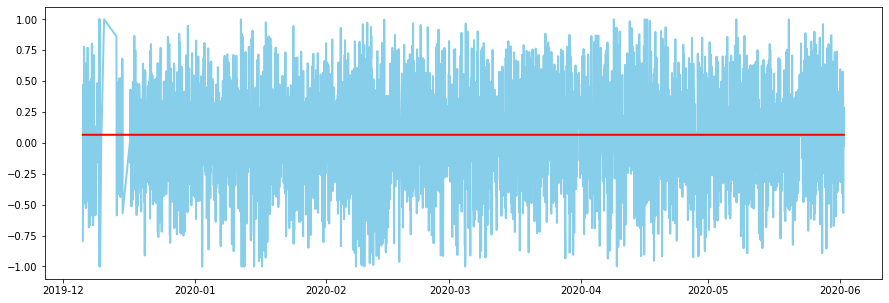

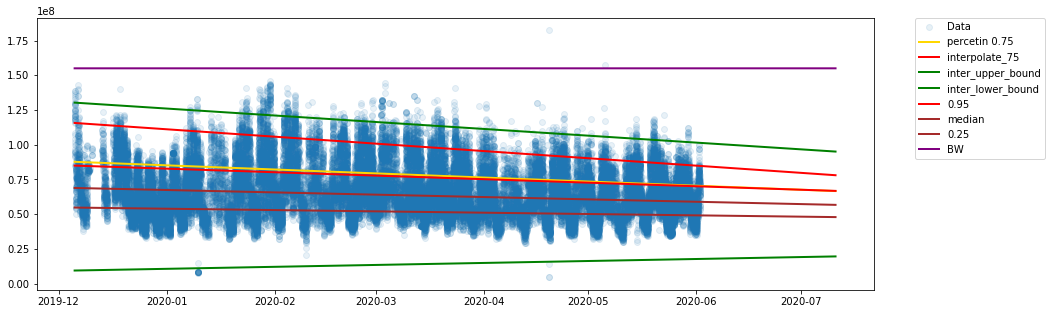

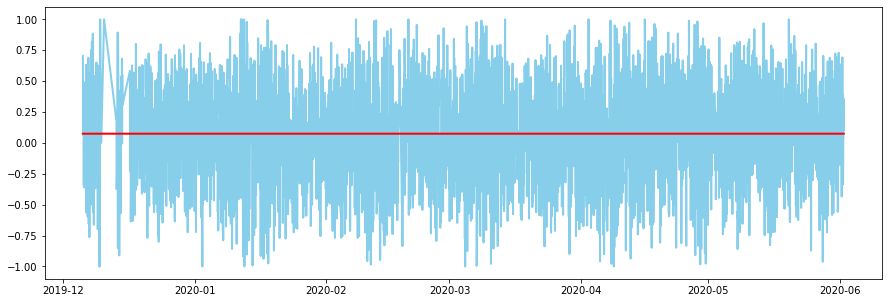

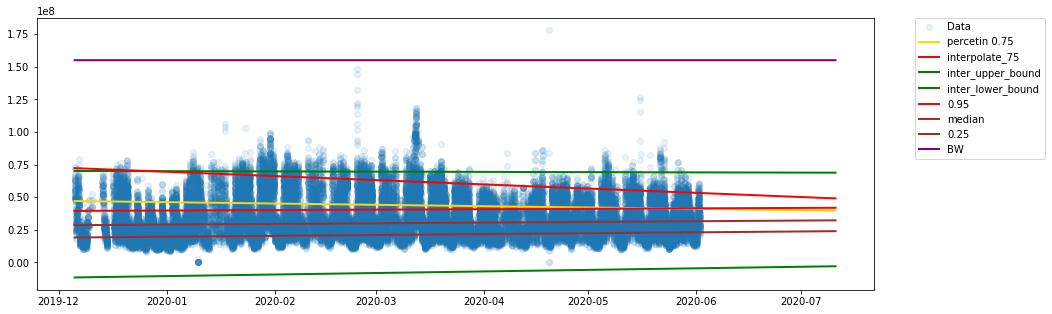

In [8]:

pipe_model_forecast(df_train[["Inbps"]],df_traffic["InBandwidth"][0],"Inbps")
pipe_model_forecast(df_train[["Outbps"]],df_traffic["OutBandwidth"][0],"Outbps")


In [10]:

def regresionesPercetiles (serie,cuantiles,meses,caudalM,porcentaje,tipoFun='lineal'): 
    #Indices y datos a usar en el modelo
    a= serie.shape[0]
    index = np.arange(1,a+1)
    #Eje x no puede ser timestamp, por lo que se genera uno auxiliar
    x = np.reshape(index, (a,1))
    #El eje y son los valores de la serie con los datos del tráfico
    y = serie.iloc[:,[0]].values[:,0]
    #Guardamos los nuevos datos para el modelo 
    data = {'x': x , 'y': y}    
    #Multiplicamos el numero de meses por los puntos en un dia y los dias en un mes
    a=a+meses*288*30
    #Valores para la predicción
    z=np.arange(1,a)
    #Creamos una lista de fechas desde la primera de la serie (entendiendo que es la posición 0 del index) hasta la ultima
    #formada por el numero de valores de la serie mas los puntos a predecir 
    date_list = [serie.index[0] + timedelta(minutes=5*x) for x in range(0, a)]
    fechas=pd.to_datetime(date_list)
    
    #Definicion del modelo
    if tipoFun == 'log':
        mod = smf.quantreg('y ~ I(np.log(x))', data)
    else: 
        mod = smf.quantreg('y ~ x', data)
    #Entrenamos el modelo con cada uno de los cuantiles
    res_all = [mod.fit(q=q) for q in cuantiles]

    #Dataframe con los datos a devolver
    fechaSupera=pd.DataFrame({'cuantiles': [] , 'fechas': []})
    valoresq=[]
    valoresf=[]
    #DataFrame con las fechas cuantil y valores
    predicciones= pd.DataFrame({'fechas': fechas[:-1]})
    for qm, res in zip(cuantiles, res_all): 
        #Transformo qm a string para que sea el valor de la columna
        predicciones[str(qm)]=res.predict({'x': z})
        # cogemos las predicciones por cada modelo y predecimos
        index=0 
        #Si los valores de prediccion superan el valor caudalMaximo * porcentaje se guardan
        for value in res.predict({'x': z}):
            if value >= caudalM*porcentaje:
                valoresq.append(qm)
                valoresf.append(fechas[index].date())
                break
            index=index+1  
    fechaSupera['cuantiles']=valoresq
    fechaSupera['fechas']=valoresf
    predicciones.set_index('fechas', inplace = True) #Lo seteo como indice 
    
    #-------------------------------------------------------------------------------
    
    #Esta funcion en la version final no estara 
    #representacionGrafica(serie,predicciones,caudalM,porcentaje)
    
    #------------------------------------------------------------------------------- 
    
    return fechaSupera, predicciones

In [11]:
def percentil(datos,percen):
    diario= datos.resample('24H').mean()
    percentil_95= pd.DataFrame(columns=('fecha', 'percentil' + str(percen)))
    percentil=[]
    for i in diario.index:
        percentil.append(np.percentile(datos.loc[(datos.index.year==i.year) & (datos.index.month==i.month) & (datos.index.day==i.day)], percen))    
    percentil_95['percentil' + str(percen)]=percentil
    percentil_95['fecha']=diario.index
    percentil_95.set_index('fecha', inplace = True)
    return percentil_95



In [12]:
def splitSerieNMes (serie,NumeroMeses=1):
    puntosHaciaAtras=NumeroMeses*288*30
    mesesAnarizar= serie[-puntosHaciaAtras:]
    datosEntrenar = serie[:-puntosHaciaAtras]
    return mesesAnarizar, datosEntrenar 

In [65]:
df_traffic.shape[0]

25570

In [13]:
#cuantil tiene formato.95 por ejemplo
def calculoMejorMes (serie,cuantil):
    mesesAnarizar, datosEntrenar = splitSerieNMes(serie,NumeroMeses=1)
    mesesAnarizar=percentil(mesesAnarizar,(cuantil[0]*100))
    #dataFrame de salida 
    errores= pd.DataFrame({})

    #Ahora que que calcular los distintos forecast con distintos tiempos de entrenamiento
    #para ello vamos a dividir datosEntrenar en series de distintos tamaños y para cada una hacer el forecast a proximo mes
    
    #Vamos a hacer saltos de dos en dos semanas hacia atras, para ello primero calculamos cuantos saltos podemos dar
    numeroSaltos=math.floor(datosEntrenar.shape[0]/(288*14))
    for i in np.arange(1,numeroSaltos+1):
        columna= 'Semana ' + str(i*2)
        puntos=i*288*14
        fechaSupera, predicciones = regresionesPercetiles(datosEntrenar[-puntos:],cuantil,2,0,1)
        prediccionesMes= predicciones.resample('24H').mean()

        
        
        
        prediccionesMes =prediccionesMes.loc[mesesAnarizar.index.values]
        
        
        
        MSE = mean_squared_error(mesesAnarizar,prediccionesMes)
        errores[columna] = [MSE]        
        #plt.plot(mesesAnarizar)
        #plt.plot(prediccionesMes)
        #datosEntrenarp=percentil(datosEntrenar[-puntos:],(cuantil[0]*100))
        #plt.plot(datosEntrenarp)

    return errores
        

  

In [18]:
def MaxMin (serie):
    max=0
    min=9999999
    for value in serie.values: 
        if value > max:
            max= value
        if value<min:
            min=value
    return max,min
        

In [19]:
def bucleErrores (serie1,serie2,percen): 
    erroresTotales1=[]
    erroresTotales2=[]


    maximo,minimo=MaxMin(serie1)
    maximo= float(maximo)
    minimo=float(minimo)
    serie1.Inbps=(serie1.Inbps-minimo)/(maximo-minimo)
    maximo,minimo=MaxMin(serie2)
    maximo= float(maximo)
    minimo=float(minimo)
    serie2.Outbps=(serie2.Outbps-minimo)/(maximo-minimo)
    for dia in np.arange(0,60):
        if (dia==0) :
            erroresTotales1.append(calculoMejorMes(serie1,percen))
            erroresTotales2.append(calculoMejorMes(serie2,percen))
        else:
            erroresTotales1.append(calculoMejorMes(serie1[:-dia*288],percen))
            erroresTotales2.append(calculoMejorMes(serie2[:-dia*288],percen))
        print(dia)
    return erroresTotales1, erroresTotales2

In [20]:
erroresTotales1, erroresTotales2 = bucleErrores(df_train[["Inbps"]],df_train[["Outbps"]],[.95])

C:\Users\Alejandro\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


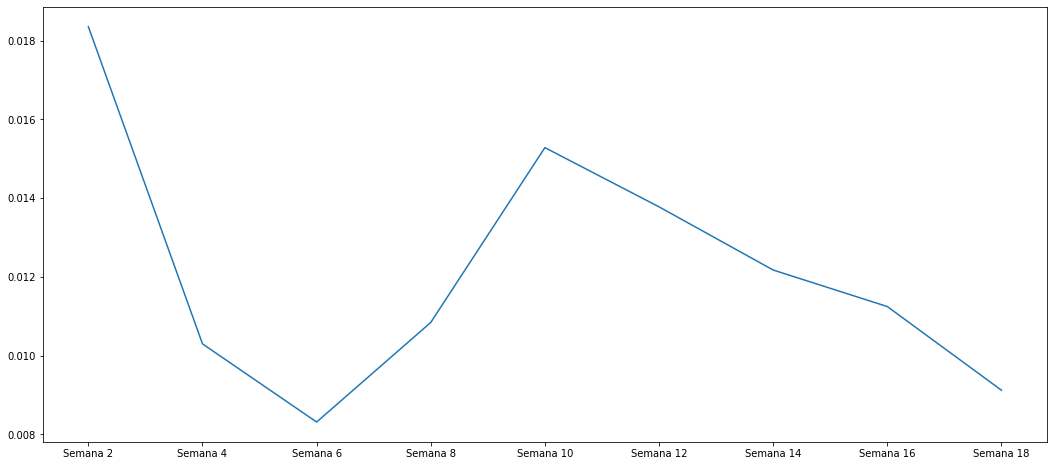

In [21]:
pd.set_option('display.max_columns', None)
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
pd.concat(erroresTotales1).describe()
pd.concat(erroresTotales1).describe().iloc[1,:].plot()

In [22]:
pd.concat(erroresTotales1).describe()

,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10,Semana 12,Semana 14,Semana 16,Semana 18
count,60.000000,60.000000,60.000000,60.000000,58.000000,44.000000,30.000000,16.000000,2.000000
mean,0.018353,0.010298,0.008312,0.010842,0.015281,0.013778,0.012173,0.011245,0.009120
std,0.012019,0.003704,0.002304,0.007699,0.012112,0.008477,0.005454,0.002259,0.000035
min,0.005670,0.004952,0.005069,0.006026,0.005277,0.006122,0.006109,0.006849,0.009095
25%,0.009660,0.007417,0.006749,0.006896,0.007046,0.006938,0.007798,0.010049,0.009108
50%,0.015427,0.009556,0.007824,0.007293,0.008289,0.008065,0.009634,0.011648,0.009120
75%,0.022997,0.011809,0.009512,0.009134,0.019199,0.021955,0.017440,0.013001,0.009133
max,0.058805,0.021884,0.014486,0.041240,0.051004,0.033066,0.022485,0.014341,0.009146


In [23]:
pd.concat(erroresTotales2).describe()

,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10,Semana 12,Semana 14,Semana 16,Semana 18
count,60.000000,60.000000,60.000000,60.000000,58.000000,44.000000,30.000000,16.000000,2.000000
mean,0.051349,0.019488,0.013017,0.013847,0.018936,0.015976,0.010463,0.008006,0.006346
std,0.097617,0.016817,0.004955,0.008683,0.016101,0.013055,0.005795,0.001618,0.000022
min,0.004882,0.005489,0.005019,0.005087,0.004847,0.005036,0.005829,0.006097,0.006330
25%,0.008431,0.007847,0.009340,0.007868,0.007016,0.006538,0.006660,0.006803,0.006338
50%,0.017081,0.012500,0.012277,0.008994,0.008283,0.008311,0.007358,0.007933,0.006346
75%,0.025747,0.022981,0.017070,0.019631,0.030591,0.024961,0.012160,0.008752,0.006353
max,0.466247,0.067507,0.024424,0.040035,0.065141,0.042629,0.024642,0.012228,0.006361


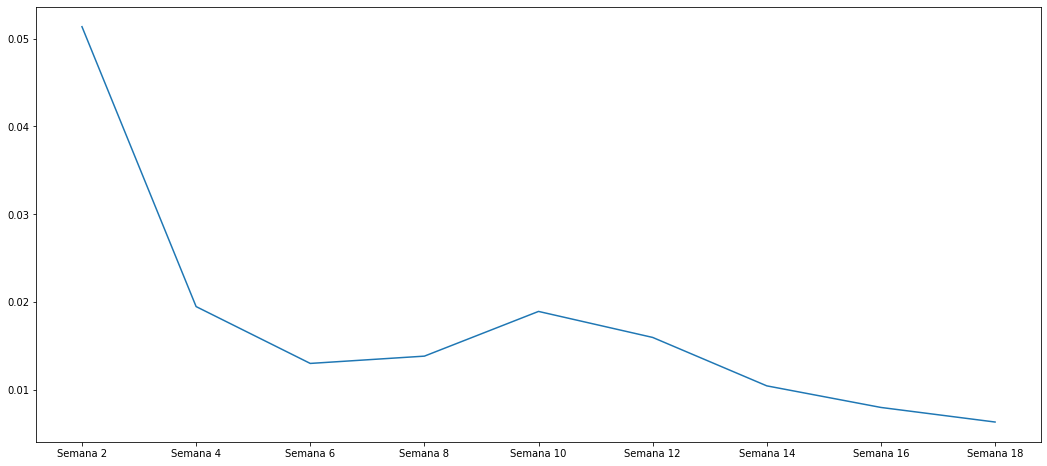

In [24]:
pd.concat(erroresTotales2).describe().iloc[1,:].plot()

In [25]:
erroresTotales1, erroresTotales2 = bucleErrores(df_train[["Inbps"]],df_train[["Outbps"]],[.75])
#


C:\Users\Alejandro\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


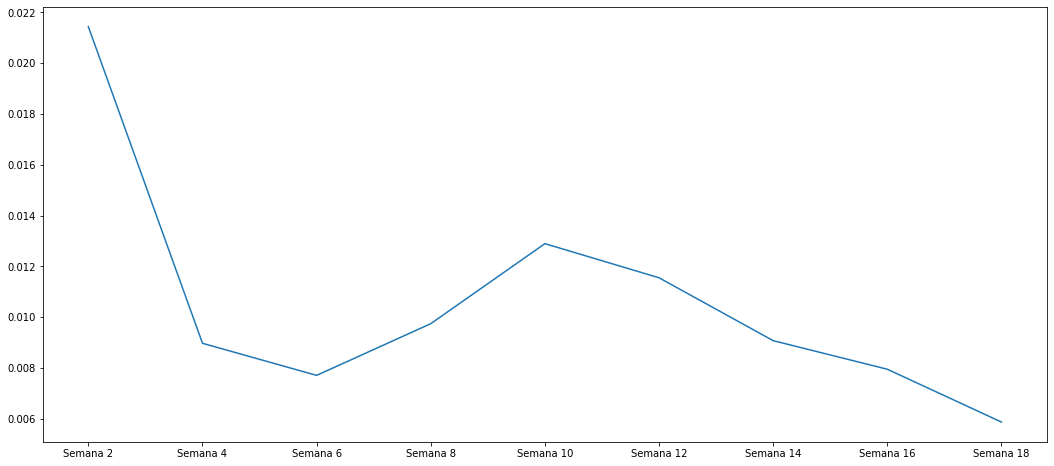

In [26]:
pd.set_option('display.max_columns', None)
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

pd.concat(erroresTotales1).describe()
pd.concat(erroresTotales1).describe().iloc[1,:].plot()

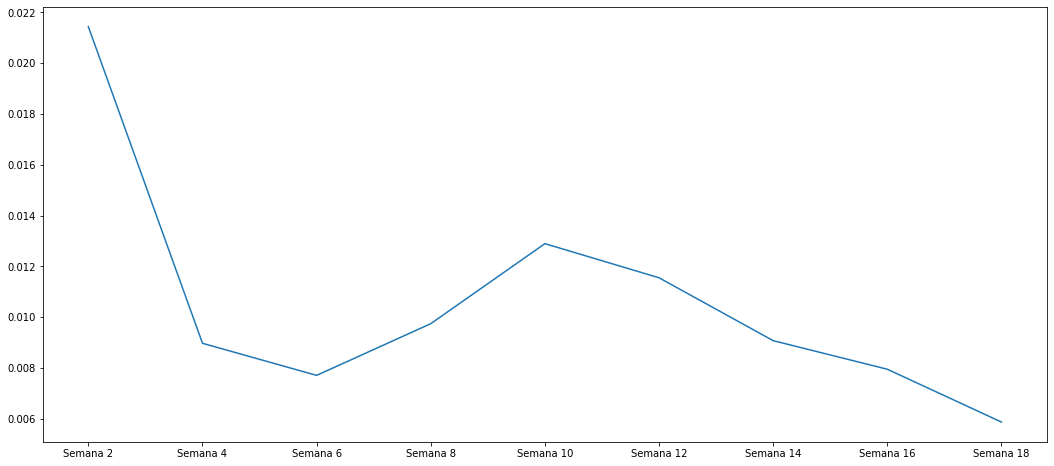

In [27]:
pd.concat(erroresTotales1).describe().iloc[1,:].plot()

In [28]:
pd.concat(erroresTotales2).describe()

,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10,Semana 12,Semana 14,Semana 16,Semana 18
count,60.000000,60.000000,60.000000,60.000000,58.000000,44.000000,30.000000,16.000000,2.000000
mean,0.026135,0.009311,0.006374,0.007469,0.011159,0.009564,0.005853,0.005036,0.004339
std,0.043240,0.006486,0.002059,0.004833,0.009130,0.006921,0.002097,0.000753,0.000032
min,0.003522,0.003286,0.003367,0.003232,0.003358,0.003522,0.003853,0.003876,0.004316
25%,0.006117,0.004718,0.004557,0.004749,0.004986,0.005022,0.004616,0.004593,0.004328
50%,0.009709,0.006841,0.006401,0.005710,0.005791,0.005555,0.004926,0.005008,0.004339
75%,0.024629,0.010814,0.007539,0.008300,0.017667,0.014284,0.006737,0.005435,0.004350
max,0.222550,0.029460,0.011696,0.027705,0.033250,0.024727,0.011766,0.006454,0.004362


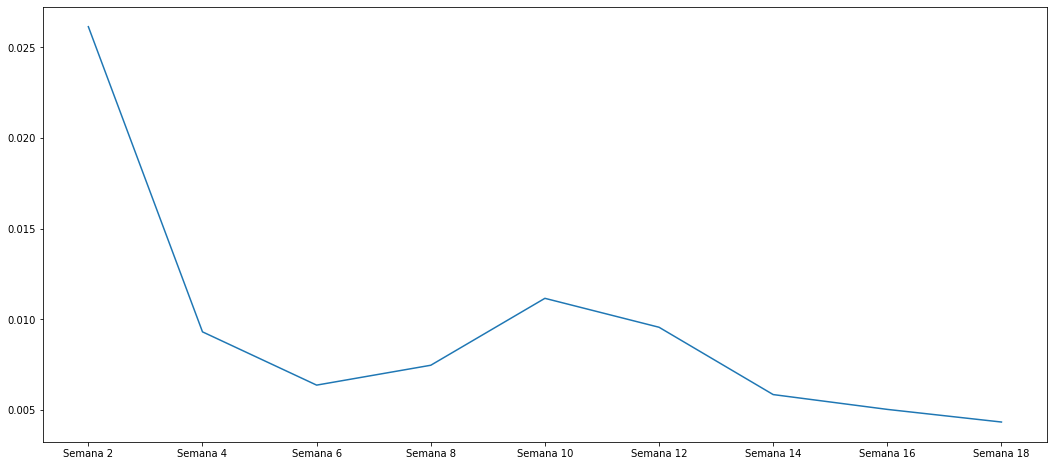

In [29]:
pd.concat(erroresTotales2).describe().iloc[1,:].plot()

In [30]:
erroresTotales1, erroresTotales2 = bucleErrores(df_train[["Inbps"]],df_train[["Outbps"]],[.5])

C:\Users\Alejandro\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [31]:
pd.concat(erroresTotales1).describe()

,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10,Semana 12,Semana 14,Semana 16,Semana 18
count,60.000000,60.000000,60.000000,60.000000,58.000000,44.000000,30.000000,16.000000,2.000000
mean,0.017972,0.005408,0.004602,0.005028,0.006166,0.006017,0.005248,0.004753,0.003572
std,0.015947,0.001996,0.001109,0.001713,0.003058,0.002094,0.001290,0.000917,0.000037
min,0.003314,0.003460,0.003127,0.003428,0.003676,0.003876,0.003869,0.003507,0.003546
25%,0.005252,0.003935,0.003797,0.003896,0.004222,0.004312,0.004189,0.004213,0.003559
50%,0.010267,0.004891,0.004258,0.004420,0.004803,0.004870,0.004816,0.004587,0.003572
75%,0.027787,0.005825,0.005098,0.005328,0.007052,0.007866,0.006378,0.004996,0.003585
max,0.059133,0.012670,0.007806,0.012758,0.015042,0.010232,0.008198,0.006653,0.003598


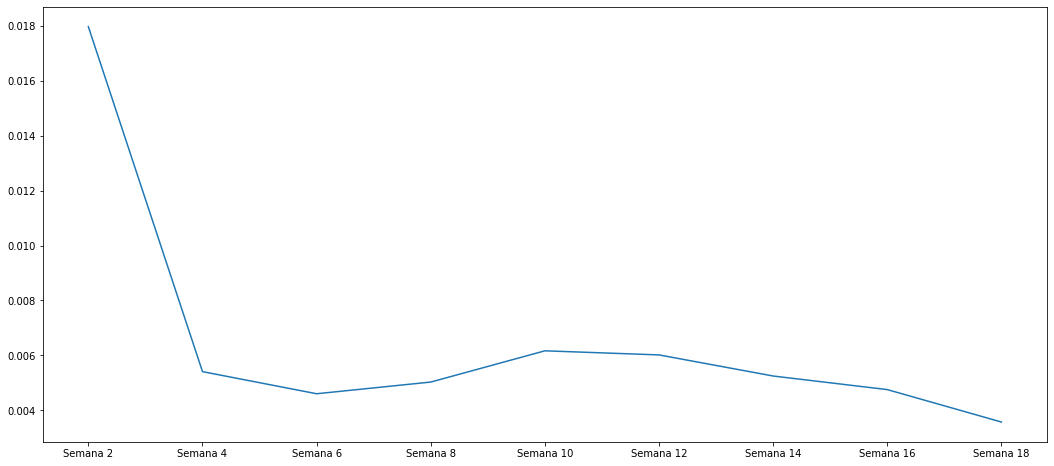

In [32]:
pd.concat(erroresTotales1).describe().iloc[1,:].plot()

In [33]:
pd.concat(erroresTotales2).describe()

,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10,Semana 12,Semana 14,Semana 16,Semana 18
count,60.000000,60.000000,60.000000,60.000000,58.000000,44.000000,30.000000,16.000000,2.000000
mean,0.016410,0.004115,0.002798,0.002406,0.003340,0.003133,0.002483,0.002350,0.001947
std,0.023210,0.002535,0.001168,0.001043,0.002181,0.001332,0.000526,0.000387,0.000054
min,0.001725,0.001664,0.001512,0.001543,0.001524,0.001787,0.001803,0.001728,0.001909
25%,0.003675,0.002203,0.002006,0.001801,0.001939,0.002172,0.002112,0.002131,0.001928
50%,0.007430,0.003296,0.002370,0.002077,0.002324,0.002413,0.002336,0.002357,0.001947
75%,0.020587,0.004781,0.003485,0.002643,0.004244,0.004327,0.002712,0.002586,0.001966
max,0.123274,0.013486,0.007425,0.007577,0.009878,0.006231,0.003577,0.003020,0.001985


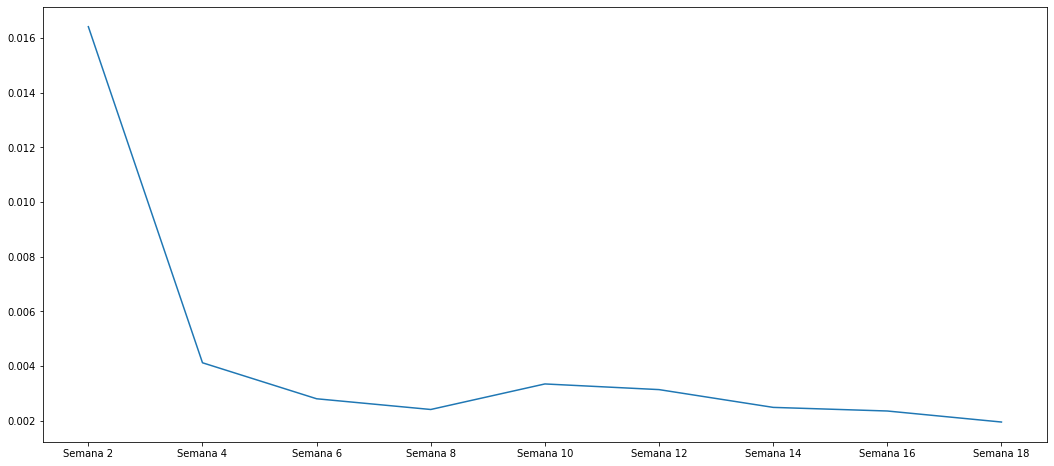

In [34]:
pd.concat(erroresTotales2).describe().iloc[1,:].plot()

In [35]:
erroresTotales1, erroresTotales2 = bucleErrores(df_train[["Inbps"]],df_train[["Outbps"]],[.25])

C:\Users\Alejandro\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [36]:
pd.concat(erroresTotales1).describe()

,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10,Semana 12,Semana 14,Semana 16,Semana 18
count,60.000000,60.000000,60.000000,60.000000,58.000000,44.000000,30.000000,16.000000,2.000000
mean,0.011435,0.003685,0.003281,0.003102,0.003114,0.002963,0.002713,0.002546,0.002282
std,0.010180,0.001789,0.001459,0.000977,0.000814,0.000475,0.000377,0.000468,0.000037
min,0.001734,0.001673,0.001824,0.002069,0.001614,0.002336,0.002285,0.002135,0.002255
25%,0.003494,0.002329,0.002193,0.002304,0.002514,0.002495,0.002456,0.002286,0.002268
50%,0.007803,0.003084,0.002753,0.002822,0.002979,0.002968,0.002642,0.002412,0.002282
75%,0.015242,0.004570,0.003800,0.003694,0.003385,0.003280,0.002841,0.002665,0.002295
max,0.038681,0.010452,0.007798,0.006402,0.005071,0.004172,0.003980,0.004125,0.002308


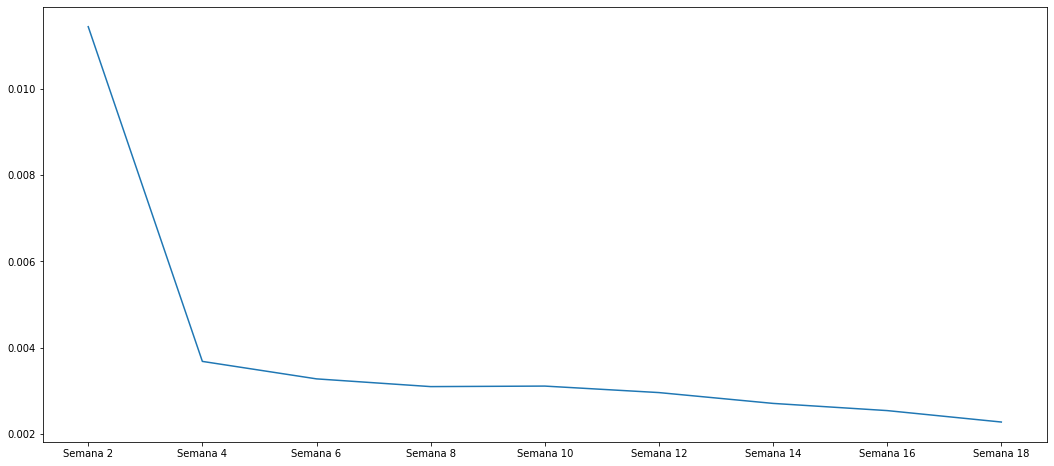

In [37]:
pd.concat(erroresTotales1).describe().iloc[1,:].plot()

In [38]:
pd.concat(erroresTotales2).describe()

,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10,Semana 12,Semana 14,Semana 16,Semana 18
count,60.000000,60.000000,60.000000,60.000000,58.000000,44.000000,30.000000,16.000000,2.000000
mean,0.006488,0.001930,0.001516,0.001308,0.001314,0.001150,0.001047,0.000985,0.000903
std,0.008049,0.001076,0.000833,0.000398,0.000391,0.000356,0.000201,0.000063,0.000013
min,0.000800,0.000630,0.000692,0.000750,0.000740,0.000669,0.000692,0.000872,0.000894
25%,0.002043,0.001097,0.000944,0.001025,0.000978,0.000867,0.000902,0.000942,0.000899
50%,0.003493,0.001605,0.001129,0.001134,0.001229,0.001098,0.001060,0.000974,0.000903
75%,0.007973,0.002541,0.001859,0.001597,0.001655,0.001364,0.001148,0.001035,0.000908
max,0.043624,0.005516,0.004026,0.002147,0.002084,0.002064,0.001464,0.001080,0.000913


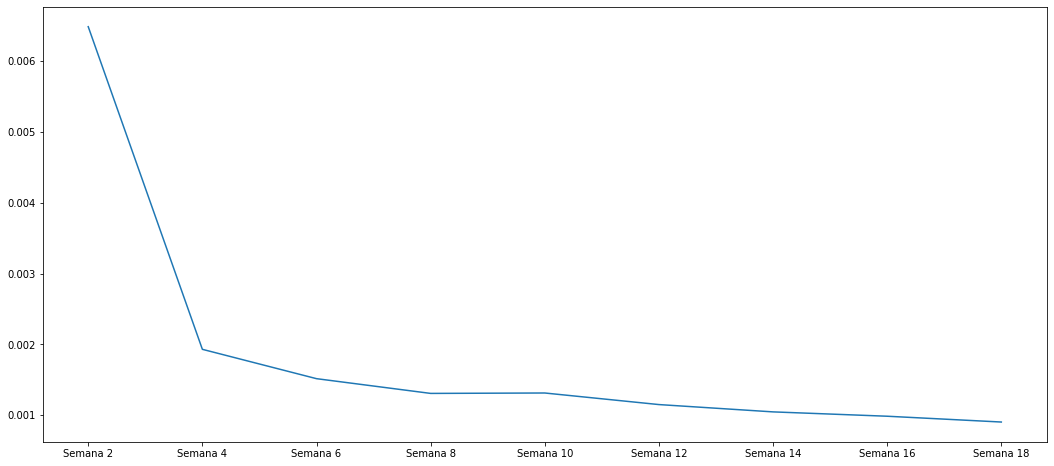

In [39]:
pd.concat(erroresTotales2).describe().iloc[1,:].plot()

In [45]:
erroresTotales1, erroresTotales2 = bucleErrores(df_train[["Inbps"]],df_train[["Outbps"]],[.75])

C:\Users\Alejandro\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [46]:
pd.concat(erroresTotales1).describe()

,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10
count,57.000000,43.000000,29.000000,15.000000,1.000000
mean,0.088162,0.043067,0.044241,0.038665,0.022496
std,0.104492,0.030714,0.029422,0.009222,NaN
min,0.012825,0.010476,0.011811,0.023962,0.022496
25%,0.025719,0.017977,0.021503,0.030426,0.022496
50%,0.051852,0.032536,0.027531,0.040455,0.022496
75%,0.099676,0.072462,0.065006,0.045763,0.022496
max,0.575971,0.125600,0.101287,0.051546,0.022496


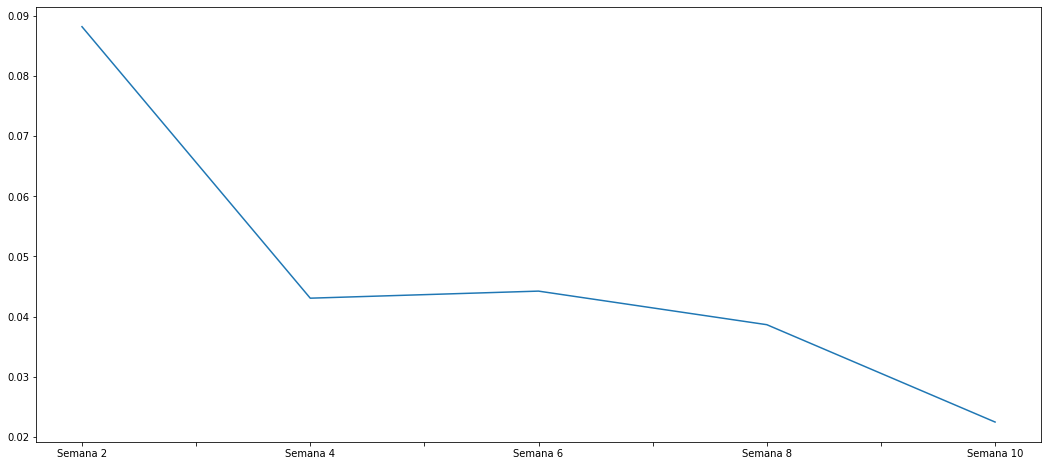

In [47]:
pd.concat(erroresTotales1).describe().iloc[1,:].plot()

In [48]:
pd.concat(erroresTotales2).describe()

,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10
count,57.000000,43.000000,29.000000,15.000000,1.00000
mean,0.063598,0.038339,0.040566,0.040315,0.02748
std,0.067931,0.034165,0.023420,0.006456,NaN
min,0.008417,0.010111,0.009646,0.025135,0.02748
25%,0.014823,0.012894,0.015763,0.037559,0.02748
50%,0.035039,0.021854,0.039763,0.040769,0.02748
75%,0.086952,0.063198,0.056406,0.044850,0.02748
max,0.305387,0.135731,0.080049,0.051205,0.02748


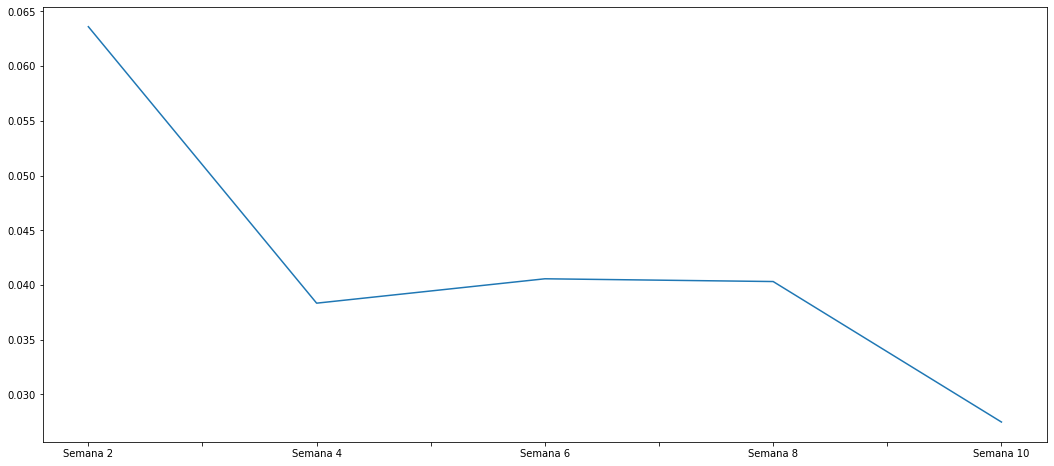

In [49]:
pd.concat(erroresTotales2).describe().iloc[1,:].plot()

In [50]:
erroresTotales1, erroresTotales2 = bucleErrores(df_train[["Inbps"]],df_train[["Outbps"]],[.5])

C:\Users\Alejandro\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [51]:
pd.concat(erroresTotales1).describe()


,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10
count,57.000000,43.000000,29.000000,15.000000,1.000000
mean,0.060338,0.018408,0.015951,0.013245,0.008124
std,0.063859,0.011187,0.010362,0.004153,NaN
min,0.006931,0.005330,0.005559,0.007502,0.008124
25%,0.014731,0.008033,0.007314,0.011055,0.008124
50%,0.042543,0.015525,0.011549,0.012270,0.008124
75%,0.080749,0.025908,0.020904,0.013901,0.008124
max,0.323226,0.048159,0.036651,0.022200,0.008124


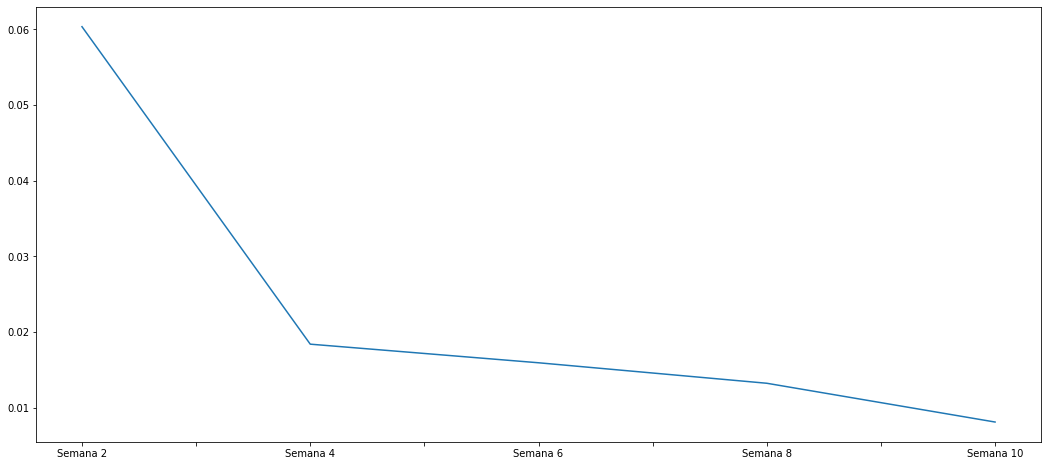

In [52]:
pd.concat(erroresTotales1).describe().iloc[1,:].plot()

In [53]:
pd.concat(erroresTotales2).describe()

,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10
count,57.000000,43.000000,29.000000,15.000000,1.000000
mean,0.032792,0.015332,0.012822,0.009981,0.005943
std,0.026608,0.013065,0.005947,0.001911,NaN
min,0.004401,0.005072,0.005301,0.005898,0.005943
25%,0.010842,0.006354,0.006936,0.009334,0.005943
50%,0.023711,0.008808,0.011980,0.010317,0.005943
75%,0.046567,0.021214,0.016093,0.010946,0.005943
max,0.109629,0.059733,0.024127,0.014036,0.005943


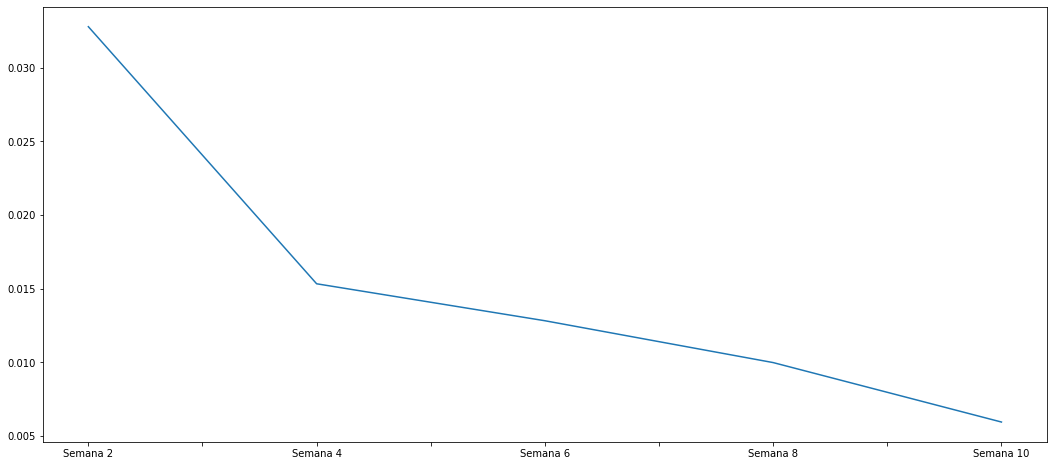

In [54]:
pd.concat(erroresTotales2).describe().iloc[1,:].plot()

In [55]:
erroresTotales1, erroresTotales2 = bucleErrores(df_train[["Inbps"]],df_train[["Outbps"]],[.25])

C:\Users\Alejandro\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [56]:
pd.concat(erroresTotales1).describe()


,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10
count,57.000000,43.000000,29.000000,15.000000,1.000000
mean,0.033979,0.008701,0.005613,0.004146,0.003486
std,0.040927,0.006469,0.002430,0.001045,NaN
min,0.002867,0.002425,0.002486,0.002966,0.003486
25%,0.007561,0.004793,0.003900,0.003422,0.003486
50%,0.017586,0.006932,0.005333,0.003823,0.003486
75%,0.036082,0.008774,0.005880,0.004547,0.003486
max,0.196972,0.027577,0.014219,0.006320,0.003486


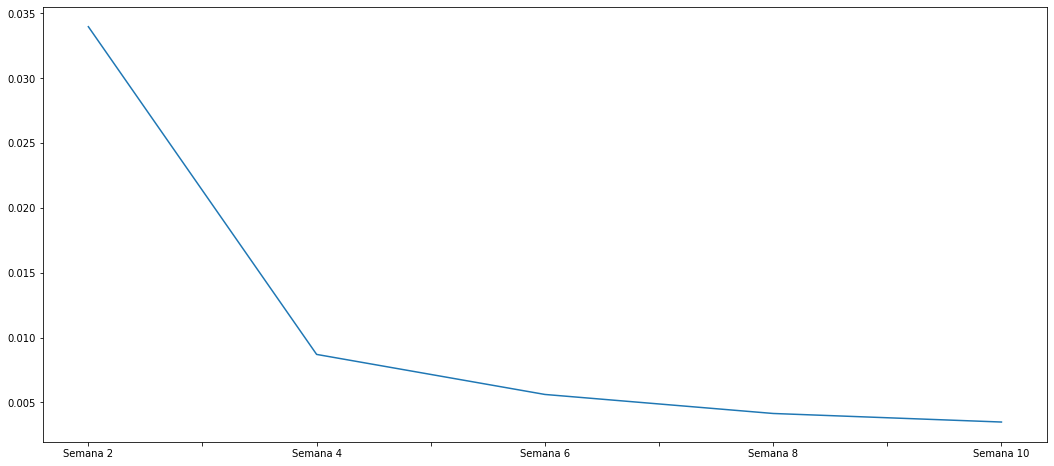

In [57]:
pd.concat(erroresTotales1).describe().iloc[1,:].plot()

In [58]:
pd.concat(erroresTotales2).describe()


,Semana 2,Semana 4,Semana 6,Semana 8,Semana 10
count,57.000000,43.000000,29.000000,15.000000,1.000000
mean,0.012257,0.005051,0.003899,0.003131,0.003003
std,0.009366,0.002656,0.000984,0.000279,NaN
min,0.002011,0.001853,0.001996,0.002684,0.003003
25%,0.004557,0.003106,0.003201,0.002925,0.003003
50%,0.009672,0.004019,0.003940,0.003082,0.003003
75%,0.018698,0.006339,0.004499,0.003317,0.003003
max,0.043612,0.013846,0.005802,0.003602,0.003003


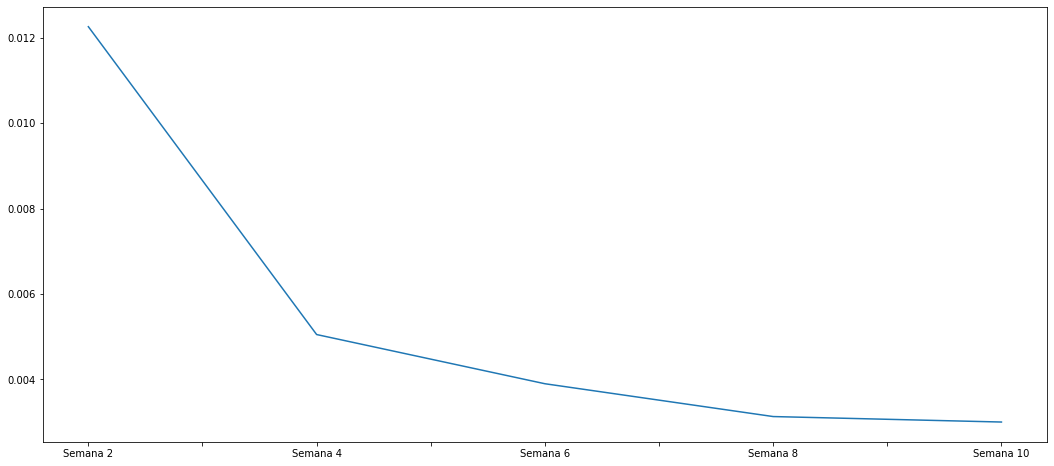

In [59]:
pd.concat(erroresTotales2).describe().iloc[1,:].plot()